# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra
from phydra.processes.main import Time, Grid0D,Boundary0D

from phydra.processes.fluxes import Flux


from phydra.processes.components import Component, AllComponents
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve

from phydra.utility.xsimlabwrappers import phydra_setup, createSingleComp, createMultiComp, specifyComps4Flux

In [3]:
from phydra.processes.forcing import Forcing

In [4]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.62.g1c273bc.dirty


In [12]:
model = xs.Model({'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 'context':GekkoContext, 
                  'Nutrient':createSingleComp(Component,'N'), 'Phytoplankton':createSingleComp(Component,'P'),
                  'Zooplankton':createSingleComp(Component,'Z'), 'Detritus':createSingleComp(Component,'D'),
                  'AllComps':AllComponents,
                  'flux':specifyComps4Flux(Flux,'Z','P'), 'solver':GekkoSolve})

model

<xsimlab.Model (11 processes, 11 inputs)>
time
    days               [in] ('time',) time in days
grid
    length             [in]
    shape              [in]
ibcs
    ibc                [in] Initial Boundary Conditions
context
Nutrient
    init               [in]
Phytoplankton
    init               [in]
Zooplankton
    init               [in]
Detritus
    init               [in]
AllComps
flux
    destruction_c2     [in]
    conversion2_c2     [in]
    inputrate_c1       [in]
solver

In [13]:
model.index_vars 

[('time', 'time'),
 ('Nutrient', 'index'),
 ('Phytoplankton', 'index'),
 ('Zooplankton', 'index'),
 ('Detritus', 'index'),
 ('AllComps', 'components')]

In [14]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 150)),
        'Nutrient':{'init':1}, 
        'Phytoplankton':{'init':.2}, #the way dims are handled need to be specified in each flux!
        'Zooplankton':{'init':0.}, 
        'Detritus':{'init':0.},
        
        'flux':{'inputrate_c1':0.1,
               'conversion2_c2':.5,
               'destruction_c2':0.1}
    },
    output_vars={
        'AllComps__outputs':None
    }
                 )

In [15]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Model Time
Initializing Gekko Context
Initializing component  N
Initializing component  P
Initializing component  Z
Initializing component  D
Initializing Flux
Assembling equation for component  N
Assembling equation for component  P
Assembling equation for component  Z
Assembling equation for component  D
SolveInit
Model context dict stores: dict_items([('shape', {'env': 1}), ('comp_dims', {'N': 1, 'P': 1, 'Z': 1, 'D': 1})])
ModelSolve done
Storing output component  N
Storing output component  P
Storing output component  Z
Storing output component  D


In [16]:
out_ds

<xarray.Dataset>
Dimensions:               (N: 1, clock: 2, components: 4, time: 150)
Coordinates:
  * clock                 (clock) int64 0 1
  * components            (components) <U1 'N' 'P' 'Z' 'D'
  * time                  (time) int64 0 1 2 3 4 5 6 ... 144 145 146 147 148 149
Dimensions without coordinates: N
Data variables:
    AllComps__outputs     (components, time) float64 1.0 1.0 1.0 ... 0.0 0.0 0.0
    Detritus__init        float64 0.0
    Nutrient__init        int64 1
    Phytoplankton__init   float64 0.2
    Zooplankton__init     float64 0.0
    flux__conversion2_c2  float64 0.5
    flux__destruction_c2  float64 0.1
    flux__inputrate_c1    float64 0.1
    grid__length          int64 1
    grid__shape           int64 1
    ibcs__ibc             float64 nan
    index                 (N) <U1 'D'
    time__days            (time) int64 0 1 2 3 4 5 6 ... 144 145 146 147 148 149

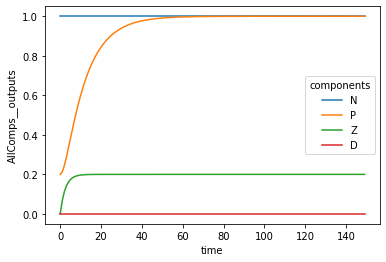

In [17]:
out_ds.AllComps__outputs.set_index(time='time',).plot.line(x='time')